In [12]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
from AFLPy.AFLData_Client import load_data, upload_data, metadata

Data

In [3]:
shots = pd.read_csv(r"/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/data/predictions/shots_xs_catboost.csv")
shots['Year'] = shots['Match_ID'].apply(lambda x: int(x.split("_")[1]))
shots['Round'] = shots['Match_ID'].apply(lambda x: x.split("_")[2])

In [4]:
shots.head()

,CD_Player_ID,Chain_Number,Team_Chain,Initial_State,Final_State,Period_Number,Period_Duration_Chain_Start,Description,Disposal,Shot_At_Goal,Behind_Detail,Order,Period_Duration,x,y,Home_Team,Away_Team,Home_Team_Direction_Q1,Venue_Width,Venue_Length,Player,Team,Match_ID,Player_ID,result,score,miss,behind,goal,predicted_result,behind_probas,goal_probas,miss_probas,xscore,angle,angle_degrees,chain_duration,description_0,description_1,description_2,description_3,distance,distance_log,distance_since_last_action,distance_squared,distance_to_goal_x,distance_to_middle_y,ground_kick,initial_state,period_duration_0,period_duration_1,period_duration_2,period_duration_3,set_shot,time_since_last_action,visible_behind_angle,visible_behind_angle_degrees,visible_goal_angle,visible_goal_angle_degrees,x_0,x_1,x_2,x_3,y_0,y_1,y_2,y_3,Year,Round
0,CD_I990609,5,Brisbane,possGain,behind,1.0,50.0,Kick,ineffective,True,NaN,48.0,118.0,44.0,12.0,Sydney,Brisbane,right,141.0,160.0,Charlie Cameron,Brisbane,AFL_2024_F4_Sydney_Brisbane,charlie_cameron,behind,1,0,1,0,goal,0.326611,0.639306,0.034083,4.162447,0.321751,18.434949,68.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,37.947332,3.636199,8.246211,1440.0,36.0,12.0,0,possGain,118.0,76.0,74.0,72.0,1,42.0,0.512821,29.382451,0.161146,9.232981,44.0,52.0,51.0,34.0,12.0,10.0,10.0,55.0,2024,F4
1,CD_I294518,12,Brisbane,possGain,behind,1.0,270.0,Kick,ineffective,True,NaN,112.0,327.0,56.0,-33.0,Sydney,Brisbane,right,141.0,160.0,Joe Daniher,Brisbane,AFL_2024_F4_Sydney_Brisbane,joe_daniher,behind,1,0,1,0,goal,0.412004,0.453756,0.134240,3.134539,0.942000,53.972627,57.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,40.804412,3.708790,8.944272,1665.0,24.0,33.0,0,possGain,327.0,292.0,291.0,290.0,1,35.0,0.292973,16.786129,0.092823,5.318374,56.0,60.0,60.0,22.0,-33.0,-25.0,-25.0,-64.0,2024,F4
2,CD_I1006126,22,Sydney,throwIn,behind,1.0,550.0,Kick,ineffective,True,NaN,196.0,558.0,64.0,15.0,Sydney,Brisbane,right,141.0,160.0,James Rowbottom,Sydney,AFL_2024_F4_Sydney_Brisbane,james_rowbottom,behind,1,0,1,0,goal,0.389350,0.460539,0.150111,3.152583,0.753151,43.152390,8.0,Kick,Loose Ball Get,Gather,Contested Knock On,21.931712,3.087934,4.472136,481.0,16.0,15.0,0,throwIn,558.0,557.0,552.0,550.0,0,1.0,0.790042,45.266082,0.217521,12.463013,64.0,60.0,59.0,61.0,15.0,17.0,15.0,16.0,2024,F4
3,CD_I997100,24,Sydney,possGain,goal,1.0,576.0,Kick,effective,True,NaN,207.0,596.0,58.0,-21.0,Sydney,Brisbane,right,141.0,160.0,Will Hayward,Sydney,AFL_2024_F4_Sydney_Brisbane,will_hayward,goal,6,0,0,1,goal,0.350931,0.598992,0.050077,3.944881,0.762147,43.667780,20.0,Kick,Free Advantage,Free For,Kick Inside 50 Result,30.413813,3.414897,7.615773,925.0,22.0,21.0,0,possGain,596.0,595.0,594.0,589.0,1,1.0,0.507180,29.059288,0.153920,8.818975,58.0,55.0,62.0,62.0,-21.0,-28.0,-30.0,-30.0,2024,F4
4,CD_I996765,25,Sydney,centreBounce,goal,1.0,659.0,Kick,effective,True,NaN,218.0,677.0,51.0,28.0,Sydney,Brisbane,right,141.0,160.0,Tom Papley,Sydney,AFL_2024_F4_Sydney_Brisbane,tom_papley,goal,6,0,0,1,behind,0.467258,0.302938,0.229804,2.284884,0.767856,43.994914,18.0,Kick,Handball Received,Handball,Gather,40.311289,3.696632,10.000000,1625.0,29.0,28.0,0,centreBounce,677.0,675.0,673.0,673.0,0,2.0,0.363247,20.812538,0.114940,6.585559,51.0,45.0,48.0,50.0,28.0,20.0,19.0,19.0,2024,F4


Highest Players

In [68]:
def create_team_match_summary(shots):
    
    shots['Opponent'] = np.where(shots['Team'] == shots['Away_Team'], shots['Home_Team'], shots['Away_Team'])
    
    shots_for = shots.groupby(['Team', 'Match_ID', 'Year']).agg(
        score=('score', 'sum'),
        xscore=('xscore', 'sum'),
        num_shots=('score', 'size'),
        num_games=('Match_ID', 'nunique')
    )
    
    shots_against = shots.groupby(['Opponent', 'Match_ID', 'Year']).agg(
        concede=('score', 'sum'),
        xconcede=('xscore', 'sum'),
        num_shots_conceded=('score', 'size'),
    )
    shots_against = shots_against.rename_axis(index={'Opponent': 'Team'}) 
       
    team_match_summary = shots_for.merge(shots_against, left_index=True, right_index=True)
    team_match_summary['score_diff'] = team_match_summary['score'] - team_match_summary['concede']
    team_match_summary['xscore_diff'] = team_match_summary['xscore'] - team_match_summary['xconcede']
    team_match_summary['shot_diff'] = team_match_summary['num_shots'] - team_match_summary['num_shots_conceded']
    
    return team_match_summary
    

In [69]:
team_match_summary = create_team_match_summary(shots)
team_match_summary.head()

score      xscore  \
Team     Match_ID                            Year                      
Adelaide AFL_2021_01_Adelaide_Geelong        2021    103   87.499619   
         AFL_2021_02_Sydney_Adelaide         2021     85  109.957014   
         AFL_2021_03_Adelaide_GoldCoast      2021     94   85.329161   
         AFL_2021_04_NorthMelbourne_Adelaide 2021    113   95.706617   
         AFL_2021_05_Adelaide_Fremantle      2021     72   66.575406   

                                                   num_shots  num_games  \
Team     Match_ID                            Year                         
Adelaide AFL_2021_01_Adelaide_Geelong        2021         30          1   
         AFL_2021_02_Sydney_Adelaide         2021         33          1   
         AFL_2021_03_Adelaide_GoldCoast      2021         31          1   
         AFL_2021_04_NorthMelbourne_Adelaide 2021         29          1   
         AFL_2021_05_Adelaide_Fremantle      2021         20          1   

                                                   concede    xconcede  \
Team     Match_ID                            Year                        
Adelaide AFL_2021_01_Adelaide_Geelong        2021       89   99.910515   
         AFL_2021_02_Sydney_Adelaide         2021      119  102.767426   
         AFL_2021_03_Adelaide_GoldCoast      2021       83   77.583860   
         AFL_2021_04_NorthMelbourne_Adelaide 2021       66   70.099597   
         AFL_2021_05_Adelaide_Fremantle      2021       80   79.448511   

                                                   num_shots_conceded  \
Team     Match_ID                            Year                       
Adelaide AFL_2021_01_Adelaide_Geelong        2021                  29   
         AFL_2021_02_Sydney_Adelaide         2021                  32   
         AFL_2021_03_Adelaide_GoldCoast      2021                  24   
         AFL_2021_04_NorthMelbourne_Adelaide 2021                  23   
         AFL_2021_05_Adelaide_Fremantle      2021                  25   

                                                   score_diff  xscore_diff  \
Team     Match_ID                            Year                            
Adelaide AFL_2021_01_Adelaide_Geelong        2021          14   -12.410897   
         AFL_2021_02_Sydney_Adelaide         2021         -34     7.189588   
         AFL_2021_03_Adelaide_GoldCoast      2021          11     7.745301   
         AFL_2021_04_NorthMelbourne_Adelaide 2021          47    25.607020   
         AFL_2021_05_Adelaide_Fremantle      2021          -8   -12.873105   

                                                   shot_diff  
Team     Match_ID                            Year             
Adelaide AFL_2021_01_Adelaide_Geelong        2021          1  
         AFL_2021_02_Sydney_Adelaide         2021          1  
         AFL_2021_03_Adelaide_GoldCoast      2021          7  
         AFL_2021_04_NorthMelbourne_Adelaide 2021          6  
         AFL_2021_05_Adelaide_Fremantle      2021         -5

In [76]:
def create_expected_score_summary(team_match_summary, group_cols, sort_by = 'xscore'):
    
    shots_groupby = team_match_summary.groupby(group_cols).agg(
        score = ('score', 'sum'),
        concede = ('concede', 'sum'),
        diff = ('score_diff', 'sum'),
        
        xscore = ('xscore', 'sum'),
        xconcede = ('xconcede', 'sum'),
        xdiff = ('xscore_diff', 'sum'),
        
        num_shots = ('num_shots', 'sum'),
        num_shots_conceded = ('num_shots_conceded', 'sum'),
        shot_diff = ('shot_diff', 'sum'),
        
        num_games = ('num_games', 'sum')
    )
    shots_groupby['score_per_shot'] = shots_groupby['score'] / shots_groupby['num_shots']
    shots_groupby['concede_per_shot'] = shots_groupby['concede'] / shots_groupby['num_shots_conceded']
    
    shots_groupby['score_per_game'] = shots_groupby['score'] / shots_groupby['num_games']
    shots_groupby['concede_per_game'] = shots_groupby['concede'] / shots_groupby['num_games']
    shots_groupby['diff_per_game'] = shots_groupby['diff'] / shots_groupby['num_games']

    shots_groupby['xscore_per_shot'] = shots_groupby['xscore'] / shots_groupby['num_shots']
    shots_groupby['xconcede_per_shot'] = shots_groupby['xconcede'] / shots_groupby['num_shots_conceded']

    shots_groupby['xscore_per_game'] = shots_groupby['xscore'] / shots_groupby['num_games']
    shots_groupby['xconcede_per_game'] = shots_groupby['xconcede'] / shots_groupby['num_games']
    shots_groupby['xdiff_per_game'] = shots_groupby['xdiff'] / shots_groupby['num_games']
    
    shots_groupby['shots_per_game'] = shots_groupby['num_shots'] / shots_groupby['num_games']
    shots_groupby['shots_conceded_per_game'] = shots_groupby['num_shots_conceded'] / shots_groupby['num_games']
    shots_groupby['shot_diff_per_game'] = shots_groupby['shot_diff'] / shots_groupby['num_games']
    
    return shots_groupby.sort_values(sort_by, ascending=False).round(2)

In [77]:
team_summary = create_expected_score_summary(team_match_summary, group_cols='Team')

In [78]:
team_summary

,score,concede,diff,xscore,xconcede,xdiff,num_shots,num_shots_conceded,shot_diff,num_games,score_per_shot,concede_per_shot,score_per_game,concede_per_game,diff_per_game,xscore_per_shot,xconcede_per_shot,xscore_per_game,xconcede_per_game,xdiff_per_game,shots_per_game,shots_conceded_per_game,shot_diff_per_game
Team,,,,,,,,,,,,,,,,,,,,,,,
Brisbane,9567,7844,1723,9457.87,7636.21,1821.67,2842,2356,486,102,3.37,3.33,93.79,76.90,16.89,3.33,3.24,92.72,74.86,17.86,27.86,23.10,4.76
Geelong,8889,7215,1674,8606.30,7256.33,1349.97,2615,2210,405,98,3.40,3.26,90.70,73.62,17.08,3.29,3.28,87.82,74.04,13.78,26.68,22.55,4.13
Sydney,8899,7519,1380,8472.69,7648.69,824.01,2588,2393,195,98,3.44,3.14,90.81,76.72,14.08,3.27,3.20,86.46,78.05,8.41,26.41,24.42,1.99
Western Bulldogs,8308,7206,1102,8443.27,7186.90,1256.37,2551,2186,365,95,3.26,3.30,87.45,75.85,11.60,3.31,3.29,88.88,75.65,13.22,26.85,23.01,3.84
Port Adelaide,8253,7342,911,8334.30,7293.85,1040.44,2600,2224,376,97,3.17,3.30,85.08,75.69,9.39,3.21,3.28,85.92,75.19,10.73,26.80,22.93,3.88
Melbourne,8186,6774,1412,8091.92,6897.61,1194.31,2543,2123,420,97,3.22,3.19,84.39,69.84,14.56,3.18,3.25,83.42,71.11,12.31,26.22,21.89,4.33
Greater Western Sydney,7948,7877,71,7807.92,8114.23,-306.32,2375,2511,-136,97,3.35,3.14,81.94,81.21,0.73,3.29,3.23,80.49,83.65,-3.16,24.48,25.89,-1.40
Collingwood,7894,7548,346,7782.67,7465.35,317.31,2347,2268,79,96,3.36,3.33,82.23,78.62,3.60,3.32,3.29,81.07,77.76,3.31,24.45,23.62,0.82
Carlton,7752,7526,226,7769.22,7556.90,212.32,2349,2261,88,94,3.30,3.33,82.47,80.06,2.40,3.31,3.34,82.65,80.39,2.26,24.99,24.05,0.94


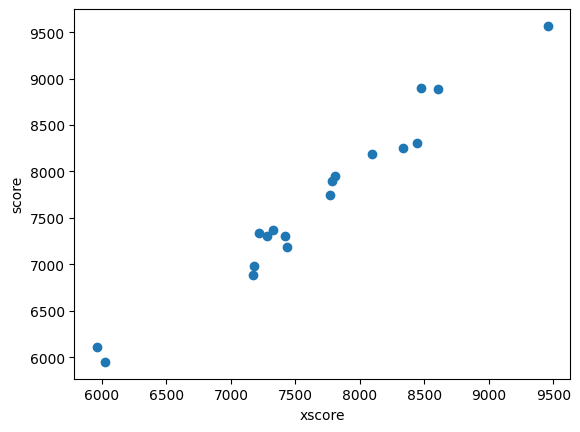

In [82]:
import matplotlib.pyplot as plt

plt.scatter(team_summary['xscore'], team_summary['score'])
plt.xlabel('xscore')
plt.ylabel('score')
plt.show()

Highest Expected Score per Game

In [81]:
team_summary.sort_values(by = 'xdiff_per_game', ascending=False)

,score,concede,diff,xscore,xconcede,xdiff,num_shots,num_shots_conceded,shot_diff,num_games,score_per_shot,concede_per_shot,score_per_game,concede_per_game,diff_per_game,xscore_per_shot,xconcede_per_shot,xscore_per_game,xconcede_per_game,xdiff_per_game,shots_per_game,shots_conceded_per_game,shot_diff_per_game
Team,,,,,,,,,,,,,,,,,,,,,,,
Brisbane,9567,7844,1723,9457.87,7636.21,1821.67,2842,2356,486,102,3.37,3.33,93.79,76.90,16.89,3.33,3.24,92.72,74.86,17.86,27.86,23.10,4.76
Geelong,8889,7215,1674,8606.30,7256.33,1349.97,2615,2210,405,98,3.40,3.26,90.70,73.62,17.08,3.29,3.28,87.82,74.04,13.78,26.68,22.55,4.13
Western Bulldogs,8308,7206,1102,8443.27,7186.90,1256.37,2551,2186,365,95,3.26,3.30,87.45,75.85,11.60,3.31,3.29,88.88,75.65,13.22,26.85,23.01,3.84
Melbourne,8186,6774,1412,8091.92,6897.61,1194.31,2543,2123,420,97,3.22,3.19,84.39,69.84,14.56,3.18,3.25,83.42,71.11,12.31,26.22,21.89,4.33
Port Adelaide,8253,7342,911,8334.30,7293.85,1040.44,2600,2224,376,97,3.17,3.30,85.08,75.69,9.39,3.21,3.28,85.92,75.19,10.73,26.80,22.93,3.88
Sydney,8899,7519,1380,8472.69,7648.69,824.01,2588,2393,195,98,3.44,3.14,90.81,76.72,14.08,3.27,3.20,86.46,78.05,8.41,26.41,24.42,1.99
Collingwood,7894,7548,346,7782.67,7465.35,317.31,2347,2268,79,96,3.36,3.33,82.23,78.62,3.60,3.32,3.29,81.07,77.76,3.31,24.45,23.62,0.82
Fremantle,7184,7119,65,7432.22,7129.45,302.77,2250,2159,91,92,3.19,3.30,78.09,77.38,0.71,3.30,3.30,80.79,77.49,3.29,24.46,23.47,0.99
Carlton,7752,7526,226,7769.22,7556.90,212.32,2349,2261,88,94,3.30,3.33,82.47,80.06,2.40,3.31,3.34,82.65,80.39,2.26,24.99,24.05,0.94


In [79]:
team_summary.sort_values(by = 'xscore_per_game', ascending=False)

,score,concede,diff,xscore,xconcede,xdiff,num_shots,num_shots_conceded,shot_diff,num_games,score_per_shot,concede_per_shot,score_per_game,concede_per_game,diff_per_game,xscore_per_shot,xconcede_per_shot,xscore_per_game,xconcede_per_game,xdiff_per_game,shots_per_game,shots_conceded_per_game,shot_diff_per_game
Team,,,,,,,,,,,,,,,,,,,,,,,
Brisbane,9567,7844,1723,9457.87,7636.21,1821.67,2842,2356,486,102,3.37,3.33,93.79,76.90,16.89,3.33,3.24,92.72,74.86,17.86,27.86,23.10,4.76
Western Bulldogs,8308,7206,1102,8443.27,7186.90,1256.37,2551,2186,365,95,3.26,3.30,87.45,75.85,11.60,3.31,3.29,88.88,75.65,13.22,26.85,23.01,3.84
Geelong,8889,7215,1674,8606.30,7256.33,1349.97,2615,2210,405,98,3.40,3.26,90.70,73.62,17.08,3.29,3.28,87.82,74.04,13.78,26.68,22.55,4.13
Sydney,8899,7519,1380,8472.69,7648.69,824.01,2588,2393,195,98,3.44,3.14,90.81,76.72,14.08,3.27,3.20,86.46,78.05,8.41,26.41,24.42,1.99
Port Adelaide,8253,7342,911,8334.30,7293.85,1040.44,2600,2224,376,97,3.17,3.30,85.08,75.69,9.39,3.21,3.28,85.92,75.19,10.73,26.80,22.93,3.88
Melbourne,8186,6774,1412,8091.92,6897.61,1194.31,2543,2123,420,97,3.22,3.19,84.39,69.84,14.56,3.18,3.25,83.42,71.11,12.31,26.22,21.89,4.33
Carlton,7752,7526,226,7769.22,7556.90,212.32,2349,2261,88,94,3.30,3.33,82.47,80.06,2.40,3.31,3.34,82.65,80.39,2.26,24.99,24.05,0.94
Richmond,7302,7935,-633,7419.15,7945.06,-525.91,2254,2417,-163,91,3.24,3.28,80.24,87.20,-6.96,3.29,3.29,81.53,87.31,-5.78,24.77,26.56,-1.79
Collingwood,7894,7548,346,7782.67,7465.35,317.31,2347,2268,79,96,3.36,3.33,82.23,78.62,3.60,3.32,3.29,81.07,77.76,3.31,24.45,23.62,0.82


In [80]:
team_summary.sort_values(by = 'xconcede_per_game', ascending=False)

,score,concede,diff,xscore,xconcede,xdiff,num_shots,num_shots_conceded,shot_diff,num_games,score_per_shot,concede_per_shot,score_per_game,concede_per_game,diff_per_game,xscore_per_shot,xconcede_per_shot,xscore_per_game,xconcede_per_game,xdiff_per_game,shots_per_game,shots_conceded_per_game,shot_diff_per_game
Team,,,,,,,,,,,,,,,,,,,,,,,
North Melbourne,5950,9132,-3182,6023.75,9010.02,-2986.27,1795,2712,-917,89,3.31,3.37,66.85,102.61,-35.75,3.36,3.32,67.68,101.24,-33.55,20.17,30.47,-10.30
West Coast,6114,9127,-3013,5961.30,8880.65,-2919.35,1847,2636,-789,90,3.31,3.46,67.93,101.41,-33.48,3.23,3.37,66.24,98.67,-32.44,20.52,29.29,-8.77
Richmond,7302,7935,-633,7419.15,7945.06,-525.91,2254,2417,-163,91,3.24,3.28,80.24,87.20,-6.96,3.29,3.29,81.53,87.31,-5.78,24.77,26.56,-1.79
Essendon,7367,7961,-594,7326.79,7706.81,-380.02,2228,2332,-104,91,3.31,3.41,80.96,87.48,-6.53,3.29,3.30,80.51,84.69,-4.18,24.48,25.63,-1.14
Hawthorn,7303,7883,-580,7278.43,7790.83,-512.41,2176,2320,-144,92,3.36,3.40,79.38,85.68,-6.30,3.34,3.36,79.11,84.68,-5.57,23.65,25.22,-1.57
Adelaide,7340,7596,-256,7219.11,7560.60,-341.49,2238,2300,-62,90,3.28,3.30,81.56,84.40,-2.84,3.23,3.29,80.21,84.01,-3.79,24.87,25.56,-0.69
Greater Western Sydney,7948,7877,71,7807.92,8114.23,-306.32,2375,2511,-136,97,3.35,3.14,81.94,81.21,0.73,3.29,3.23,80.49,83.65,-3.16,24.48,25.89,-1.40
Gold Coast,6986,7550,-564,7177.33,7523.48,-346.15,2159,2297,-138,90,3.24,3.29,77.62,83.89,-6.27,3.32,3.28,79.75,83.59,-3.85,23.99,25.52,-1.53
Carlton,7752,7526,226,7769.22,7556.90,212.32,2349,2261,88,94,3.30,3.33,82.47,80.06,2.40,3.31,3.34,82.65,80.39,2.26,24.99,24.05,0.94


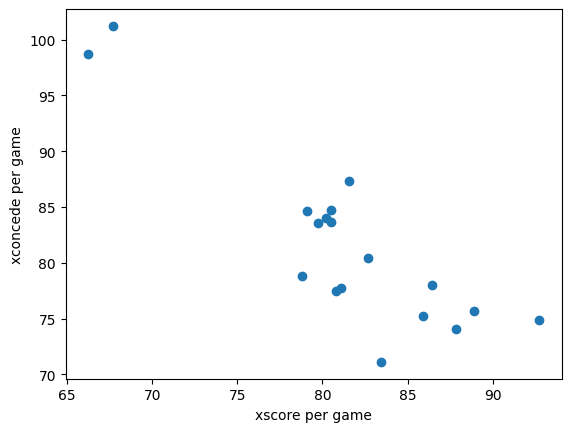

In [48]:
import matplotlib.pyplot as plt

plt.scatter(team_summary['xscore_per_game'], team_summary['xconcede_per_game'])
plt.xlabel('xscore per game')
plt.ylabel('xconcede per game')
plt.show()

Highest Expected Score per Shot

In [43]:
team_summary.sort_values(by = 'xscore_per_shot', ascending=False)

,score,concede,xscore,xconcede,num_shots,num_shots_conceded,num_games,score_per_shot,concede_per_shot,score_per_game,concede_per_game,xscore_per_shot,xconcede_per_shot,xscore_per_game,xconcede_per_game,shots_per_game,shots_conceded_per_game
Team,,,,,,,,,,,,,,,,,
St Kilda,6889,6977,7171.599482,7172.865560,2117,2169,91,3.254133,3.295701,75.703297,76.670330,3.387624,3.388222,78.808786,78.822698,23.263736,23.835165
North Melbourne,5950,9132,6023.751080,9010.017014,1795,2712,89,3.314763,5.087465,66.853933,102.606742,3.355850,5.019508,67.682596,101.236146,20.168539,30.471910
Hawthorn,7303,7883,7278.429256,7790.834383,2176,2320,92,3.356158,3.622702,79.380435,85.684783,3.344866,3.580347,79.113361,84.682982,23.652174,25.217391
Brisbane,9567,7844,9457.872940,7636.207138,2842,2356,102,3.366291,2.760028,93.794118,76.901961,3.327893,2.686913,92.724245,74.864776,27.862745,23.098039
Gold Coast,6986,7550,7177.328916,7523.481851,2159,2297,90,3.235757,3.496989,77.622222,83.888889,3.324377,3.484707,79.748099,83.594243,23.988889,25.522222
Collingwood,7894,7548,7782.665598,7465.353596,2347,2268,96,3.363443,3.216020,82.229167,78.625000,3.316006,3.180807,81.069433,77.764100,24.447917,23.625000
Western Bulldogs,8308,7206,8443.265732,7186.899960,2551,2186,95,3.256762,2.824775,87.452632,75.852632,3.309787,2.817287,88.876481,75.651579,26.852632,23.010526
Carlton,7752,7526,7769.223797,7556.899758,2349,2261,94,3.300128,3.203917,82.468085,80.063830,3.307460,3.217071,82.651317,80.392551,24.989362,24.053191
Fremantle,7184,7119,7432.222472,7129.451701,2250,2159,92,3.192889,3.164000,78.086957,77.380435,3.303210,3.168645,80.785027,77.494040,24.456522,23.467391


In [83]:
team_summary.sort_values(by = 'xconcede_per_shot', ascending=False)

,score,concede,diff,xscore,xconcede,xdiff,num_shots,num_shots_conceded,shot_diff,num_games,score_per_shot,concede_per_shot,score_per_game,concede_per_game,diff_per_game,xscore_per_shot,xconcede_per_shot,xscore_per_game,xconcede_per_game,xdiff_per_game,shots_per_game,shots_conceded_per_game,shot_diff_per_game
Team,,,,,,,,,,,,,,,,,,,,,,,
West Coast,6114,9127,-3013,5961.30,8880.65,-2919.35,1847,2636,-789,90,3.31,3.46,67.93,101.41,-33.48,3.23,3.37,66.24,98.67,-32.44,20.52,29.29,-8.77
Hawthorn,7303,7883,-580,7278.43,7790.83,-512.41,2176,2320,-144,92,3.36,3.40,79.38,85.68,-6.30,3.34,3.36,79.11,84.68,-5.57,23.65,25.22,-1.57
Carlton,7752,7526,226,7769.22,7556.90,212.32,2349,2261,88,94,3.30,3.33,82.47,80.06,2.40,3.31,3.34,82.65,80.39,2.26,24.99,24.05,0.94
North Melbourne,5950,9132,-3182,6023.75,9010.02,-2986.27,1795,2712,-917,89,3.31,3.37,66.85,102.61,-35.75,3.36,3.32,67.68,101.24,-33.55,20.17,30.47,-10.30
St Kilda,6889,6977,-88,7171.60,7172.87,-1.27,2117,2169,-52,91,3.25,3.22,75.70,76.67,-0.97,3.39,3.31,78.81,78.82,-0.01,23.26,23.84,-0.57
Essendon,7367,7961,-594,7326.79,7706.81,-380.02,2228,2332,-104,91,3.31,3.41,80.96,87.48,-6.53,3.29,3.30,80.51,84.69,-4.18,24.48,25.63,-1.14
Fremantle,7184,7119,65,7432.22,7129.45,302.77,2250,2159,91,92,3.19,3.30,78.09,77.38,0.71,3.30,3.30,80.79,77.49,3.29,24.46,23.47,0.99
Collingwood,7894,7548,346,7782.67,7465.35,317.31,2347,2268,79,96,3.36,3.33,82.23,78.62,3.60,3.32,3.29,81.07,77.76,3.31,24.45,23.62,0.82
Richmond,7302,7935,-633,7419.15,7945.06,-525.91,2254,2417,-163,91,3.24,3.28,80.24,87.20,-6.96,3.29,3.29,81.53,87.31,-5.78,24.77,26.56,-1.79


Plotting Expected Score per Shot v Shots per Game

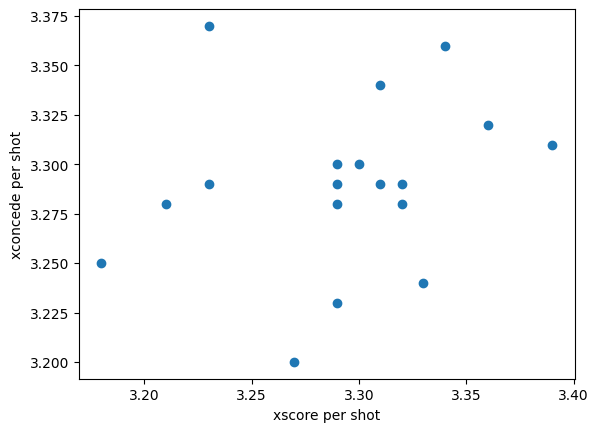

In [84]:
import matplotlib.pyplot as plt

plt.scatter(team_summary['xscore_per_shot'], team_summary['xconcede_per_shot'])
plt.xlabel('xscore per shot')
plt.ylabel('xconcede per shot')
plt.show()

Years

In [87]:
team_year_summary = create_expected_score_summary(team_match_summary, group_cols=['Year', 'Team'], sort_by='xdiff')

In [89]:
team_year_summary.head(10)

score  concede  diff   xscore  xconcede   xdiff  \
Year Team                                                                
2022 Geelong            2419     1645   774  2331.59   1618.87  712.72   
2021 Melbourne          2205     1561   644  2250.07   1582.13  667.94   
2024 Brisbane           2498     2034   464  2570.53   1957.92  612.62   
2021 Western Bulldogs   2315     1776   539  2361.49   1848.88  512.60   
2023 Brisbane           2420     1960   460  2414.14   1916.91  497.23   
2021 Brisbane           2251     1776   475  2242.94   1763.21  479.73   
2024 Hawthorn           2258     1877   381  2242.78   1800.96  441.82   
     Western Bulldogs   2074     1784   290  2161.05   1747.72  413.33   
2022 Melbourne          2040     1641   399  2045.55   1644.04  401.52   
     Richmond           2262     1874   388  2222.40   1841.62  380.78   

                       num_shots  num_shots_conceded  shot_diff  num_games  \
Year Team                                                                    
2022 Geelong                 717                 488        229         25   
2021 Melbourne               709                 491        218         25   
2024 Brisbane                776                 608        168         27   
2021 Western Bulldogs        706                 571        135         26   
2023 Brisbane                725                 587        138         26   
2021 Brisbane                666                 549        117         24   
2024 Hawthorn                671                 554        117         25   
     Western Bulldogs        644                 525        119         23   
2022 Melbourne               639                 507        132         24   
     Richmond                659                 576         83         23   

                       score_per_shot  concede_per_shot  score_per_game  \
Year Team                                                                 
2022 Geelong                     3.37              3.37           96.76   
2021 Melbourne                   3.11              3.18           88.20   
2024 Brisbane                    3.22              3.35           92.52   
2021 Western Bulldogs            3.28              3.11           89.04   
2023 Brisbane                    3.34              3.34           93.08   
2021 Brisbane                    3.38              3.23           93.79   
2024 Hawthorn                    3.37              3.39           90.32   
     Western Bulldogs            3.22              3.40           90.17   
2022 Melbourne                   3.19              3.24           85.00   
     Richmond                    3.43              3.25           98.35   

                       concede_per_game  diff_per_game  xscore_per_shot  \
Year Team                                                                 
2022 Geelong                      65.80          30.96             3.25   
2021 Melbourne                    62.44          25.76             3.17   
2024 Brisbane                     75.33          17.19             3.31   
2021 Western Bulldogs             68.31          20.73             3.34   
2023 Brisbane                     75.38          17.69             3.33   
2021 Brisbane                     74.00          19.79             3.37   
2024 Hawthorn                     75.08          15.24             3.34   
     Western Bulldogs             77.57          12.61             3.36   
2022 Melbourne                    68.38          16.62             3.20   
     Richmond                     81.48          16.87             3.37   

                       xconcede_per_shot  xscore_per_game  xconcede_per_game  \
Year Team                                                                      
2022 Geelong                        3.32            93.26              64.75   
2021 Melbourne                      3.22            90.00              63.29   
2024 Brisbane                       3.22            95.20              72.5

In [90]:
team_year_summary.tail(10)

score  concede  diff   xscore  xconcede    xdiff  \
Year Team                                                                       
2021 Hawthorn                 1603     1896  -293  1574.78   1900.44  -325.66   
2022 Greater Western Sydney   1608     1907  -299  1602.90   1952.67  -349.76   
2024 West Coast               1562     2234  -672  1583.01   2150.07  -567.07   
2023 North Melbourne          1632     2287  -655  1627.61   2246.93  -619.32   
2021 North Melbourne          1445     2091  -646  1507.71   2132.12  -624.41   
2024 Richmond                 1451     2322  -871  1531.79   2291.80  -760.01   
     North Melbourne          1562     2390  -828  1429.68   2284.70  -855.02   
2022 North Melbourne          1311     2364 -1053  1458.75   2346.27  -887.52   
     West Coast               1411     2363  -952  1315.15   2243.69  -928.54   
2023 West Coast               1393     2655 -1262  1423.96   2602.68 -1178.72   

                             num_shots  num_shots_conceded  shot_diff  \
Year Team                                                               
2021 Hawthorn                      471                 560        -89   
2022 Greater Western Sydney        480                 602       -122   
2024 West Coast                    488                 632       -144   
2023 North Melbourne               475                 676       -201   
2021 North Melbourne               463                 642       -179   
2024 Richmond                      473                 682       -209   
     North Melbourne               422                 684       -262   
2022 North Melbourne               435                 710       -275   
     West Coast                    396                 671       -275   
2023 West Coast                    452                 764       -312   

                             num_games  score_per_shot  concede_per_shot  \
Year Team                                                                  
2021 Hawthorn                       22            3.40              3.39   
2022 Greater Western Sydney         22            3.35              3.17   
2024 West Coast                     23            3.20              3.53   
2023 North Melbourne                23            3.44              3.38   
2021 North Melbourne                22            3.12              3.26   
2024 Richmond                       23            3.07              3.40   
     North Melbourne                22            3.70              3.49   
2022 North Melbourne                22            3.01              3.33   
     West Coast                     22            3.56              3.52   
2023 West Coast                     23            3.08              3.48   

                             score_per_game  concede_per_game  diff_per_game  \
Year Team                                                                      
2021 Hawthorn                         72.86             86.18         -13.32   
2022 Greater Western Sydney           73.09             86.68         -13.59   
2024 West Coast                       67.91             97.13         -29.22   
2023 North Melbourne                  70.96             99.43         -28.48   
2021 North Melbourne                  65.68             95.05         -29.36   
2024 Richmond                         63.09            100.96         -37.87   
     North Melbourne                  71.00            108.64         -37.64   
2022 North Melbourne                  59.59            107.45         -47.86   
     West Coast                       64.14            107.41         -43.27   
2023 West Coast                       60.57            115.43         -54.87   

                             xscore_per_shot  xconcede_per_shot  \
Year Team                                                         
2021 Hawthorn                           3.34               3.39   
2022 Greater Western Sydney             3.34               3.24   
2024 West Coast                      

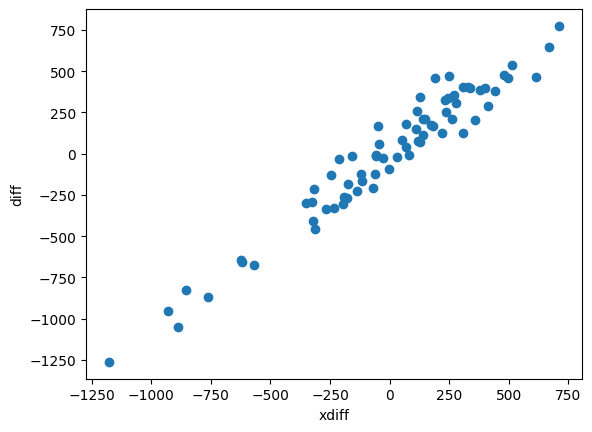

In [92]:
import matplotlib.pyplot as plt

plt.scatter(team_year_summary['xdiff'], team_year_summary['diff'])
plt.xlabel('xdiff')
plt.ylabel('diff')
plt.show()

Highest Expected Score per Game

In [94]:
team_year_summary.sort_values(by = 'xdiff_per_game', ascending=False).head()

score  concede  diff   xscore  xconcede   xdiff  \
Year Team                                                                
2022 Geelong            2419     1645   774  2331.59   1618.87  712.72   
2021 Melbourne          2205     1561   644  2250.07   1582.13  667.94   
2024 Brisbane           2498     2034   464  2570.53   1957.92  612.62   
2021 Brisbane           2251     1776   475  2242.94   1763.21  479.73   
     Western Bulldogs   2315     1776   539  2361.49   1848.88  512.60   

                       num_shots  num_shots_conceded  shot_diff  num_games  \
Year Team                                                                    
2022 Geelong                 717                 488        229         25   
2021 Melbourne               709                 491        218         25   
2024 Brisbane                776                 608        168         27   
2021 Brisbane                666                 549        117         24   
     Western Bulldogs        706                 571        135         26   

                       score_per_shot  concede_per_shot  score_per_game  \
Year Team                                                                 
2022 Geelong                     3.37              3.37           96.76   
2021 Melbourne                   3.11              3.18           88.20   
2024 Brisbane                    3.22              3.35           92.52   
2021 Brisbane                    3.38              3.23           93.79   
     Western Bulldogs            3.28              3.11           89.04   

                       concede_per_game  diff_per_game  xscore_per_shot  \
Year Team                                                                 
2022 Geelong                      65.80          30.96             3.25   
2021 Melbourne                    62.44          25.76             3.17   
2024 Brisbane                     75.33          17.19             3.31   
2021 Brisbane                     74.00          19.79             3.37   
     Western Bulldogs             68.31          20.73             3.34   

                       xconcede_per_shot  xscore_per_game  xconcede_per_game  \
Year Team                                                                      
2022 Geelong                        3.32            93.26              64.75   
2021 Melbourne                      3.22            90.00              63.29   
2024 Brisbane                       3.22            95.20              72.52   
2021 Brisbane                       3.21            93.46              73.47   
     Western Bulldogs               3.24            90.83              71.11   

                       xdiff_per_game  shots_per_game  \
Year Team                                               
2022 Geelong                    28.51           28.68   
2021 Melbourne                  26.72           28.36   
2024 Brisbane                   22.69           28.74   
2021 Brisbane                   19.99           27.75   
     Western Bulldogs           19.72           27.15   

                       shots_conceded_per_game  shot_diff_per_game  
Year Team                                                           
2022 Geelong                             19.52                9.16  
2021 Melbourne                           19.64                8.72  
2024 Brisbane                            22.52                6.22  
2021 Brisbane                            22.88                4.88  
     Western Bulldogs                    21.96                5.19

In [96]:
team_year_summary.sort_values(by = 'xscore_per_game', ascending=False).head()

score  concede  diff   xscore  xconcede   xdiff  \
Year Team                                                                
2022 Richmond           2262     1874   388  2222.40   1841.62  380.78   
2024 Brisbane           2498     2034   464  2570.53   1957.92  612.62   
     Western Bulldogs   2074     1784   290  2161.05   1747.72  413.33   
2023 Port Adelaide      2314     2112   202  2339.92   1982.36  357.56   
2021 Brisbane           2251     1776   475  2242.94   1763.21  479.73   

                       num_shots  num_shots_conceded  shot_diff  num_games  \
Year Team                                                                    
2022 Richmond                659                 576         83         23   
2024 Brisbane                776                 608        168         27   
     Western Bulldogs        644                 525        119         23   
2023 Port Adelaide           724                 613        111         25   
2021 Brisbane                666                 549        117         24   

                       score_per_shot  concede_per_shot  score_per_game  \
Year Team                                                                 
2022 Richmond                    3.43              3.25           98.35   
2024 Brisbane                    3.22              3.35           92.52   
     Western Bulldogs            3.22              3.40           90.17   
2023 Port Adelaide               3.20              3.45           92.56   
2021 Brisbane                    3.38              3.23           93.79   

                       concede_per_game  diff_per_game  xscore_per_shot  \
Year Team                                                                 
2022 Richmond                     81.48          16.87             3.37   
2024 Brisbane                     75.33          17.19             3.31   
     Western Bulldogs             77.57          12.61             3.36   
2023 Port Adelaide                84.48           8.08             3.23   
2021 Brisbane                     74.00          19.79             3.37   

                       xconcede_per_shot  xscore_per_game  xconcede_per_game  \
Year Team                                                                      
2022 Richmond                       3.20            96.63              80.07   
2024 Brisbane                       3.22            95.20              72.52   
     Western Bulldogs               3.33            93.96              75.99   
2023 Port Adelaide                  3.23            93.60              79.29   
2021 Brisbane                       3.21            93.46              73.47   

                       xdiff_per_game  shots_per_game  \
Year Team                                               
2022 Richmond                   16.56           28.65   
2024 Brisbane                   22.69           28.74   
     Western Bulldogs           17.97           28.00   
2023 Port Adelaide              14.30           28.96   
2021 Brisbane                   19.99           27.75   

                       shots_conceded_per_game  shot_diff_per_game  
Year Team                                                           
2022 Richmond                            25.04                3.61  
2024 Brisbane                            22.52                6.22  
     Western Bulldogs                    22.83                5.17  
2023 Port Adelaide                       24.52                4.44  
2021 Brisbane                            22.88                4.88

In [97]:
team_year_summary.sort_values(by = 'xconcede_per_game', ascending=True).head()

score  concede  diff   xscore  xconcede   xdiff  num_shots  \
Year Team                                                                    
2021 Melbourne   2205     1561   644  2250.07   1582.13  667.94        709   
2022 Geelong     2419     1645   774  2331.59   1618.87  712.72        717   
     Melbourne   2040     1641   399  2045.55   1644.04  401.52        639   
     Fremantle   1870     1618   252  1916.60   1679.18  237.43        593   
2021 Geelong     2003     1697   306  2035.05   1756.54  278.51        614   

                num_shots_conceded  shot_diff  num_games  score_per_shot  \
Year Team                                                                  
2021 Melbourne                 491        218         25            3.11   
2022 Geelong                   488        229         25            3.37   
     Melbourne                 507        132         24            3.19   
     Fremantle                 512         81         24            3.15   
2021 Geelong                   546         68         25            3.26   

                concede_per_shot  score_per_game  concede_per_game  \
Year Team                                                            
2021 Melbourne              3.18           88.20             62.44   
2022 Geelong                3.37           96.76             65.80   
     Melbourne              3.24           85.00             68.38   
     Fremantle              3.16           77.92             67.42   
2021 Geelong                3.11           80.12             67.88   

                diff_per_game  xscore_per_shot  xconcede_per_shot  \
Year Team                                                           
2021 Melbourne          25.76             3.17               3.22   
2022 Geelong            30.96             3.25               3.32   
     Melbourne          16.62             3.20               3.24   
     Fremantle          10.50             3.23               3.28   
2021 Geelong            12.24             3.31               3.22   

                xscore_per_game  xconcede_per_game  xdiff_per_game  \
Year Team                                                            
2021 Melbourne            90.00              63.29           26.72   
2022 Geelong              93.26              64.75           28.51   
     Melbourne            85.23              68.50           16.73   
     Fremantle            79.86              69.97            9.89   
2021 Geelong              81.40              70.26           11.14   

                shots_per_game  shots_conceded_per_game  shot_diff_per_game  
Year Team                                                                    
2021 Melbourne           28.36                    19.64                8.72  
2022 Geelong             28.68                    19.52                9.16  
     Melbourne           26.62                    21.12                5.50  
     Fremantle           24.71                    21.33                3.38  
2021 Geelong             24.56                    21.84                2.72

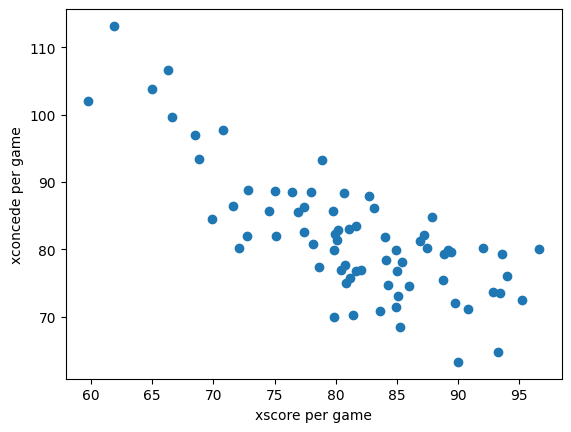

In [98]:
import matplotlib.pyplot as plt

plt.scatter(team_year_summary['xscore_per_game'], team_year_summary['xconcede_per_game'])
plt.xlabel('xscore per game')
plt.ylabel('xconcede per game')
plt.show()

Highest Expected Score per Shot

In [100]:
team_year_summary.sort_values(by = 'xscore_per_shot', ascending=False).head()

score  concede  diff   xscore  xconcede   xdiff  \
Year Team                                                               
2022 Hawthorn          1783     1995  -212  1735.56   2051.65 -316.09   
2023 North Melbourne   1632     2287  -655  1627.61   2246.93 -619.32   
     St Kilda          1831     1719   112  1940.46   1799.98  140.48   
2024 St Kilda          1720     1740   -20  1808.41   1778.43   29.98   
2022 Gold Coast        1833     1795    38  1933.77   1864.62   69.15   

                      num_shots  num_shots_conceded  shot_diff  num_games  \
Year Team                                                                   
2022 Hawthorn               504                 605       -101         22   
2023 North Melbourne        475                 676       -201         23   
     St Kilda               567                 565          2         24   
2024 St Kilda               531                 543        -12         23   
2022 Gold Coast             568                 565          3         22   

                      score_per_shot  concede_per_shot  score_per_game  \
Year Team                                                                
2022 Hawthorn                   3.54              3.30           81.05   
2023 North Melbourne            3.44              3.38           70.96   
     St Kilda                   3.23              3.04           76.29   
2024 St Kilda                   3.24              3.20           74.78   
2022 Gold Coast                 3.23              3.18           83.32   

                      concede_per_game  diff_per_game  xscore_per_shot  \
Year Team                                                                
2022 Hawthorn                    90.68          -9.64             3.44   
2023 North Melbourne             99.43         -28.48             3.43   
     St Kilda                    71.62           4.67             3.42   
2024 St Kilda                    75.65          -0.87             3.41   
2022 Gold Coast                  81.59           1.73             3.40   

                      xconcede_per_shot  xscore_per_game  xconcede_per_game  \
Year Team                                                                     
2022 Hawthorn                      3.39            78.89              93.26   
2023 North Melbourne               3.32            70.77              97.69   
     St Kilda                      3.19            80.85              75.00   
2024 St Kilda                      3.28            78.63              77.32   
2022 Gold Coast                    3.30            87.90              84.76   

                      xdiff_per_game  shots_per_game  shots_conceded_per_game  \
Year Team                                                                       
2022 Hawthorn                 -14.37           22.91                    27.50   
2023 North Melbourne          -26.93           20.65                    29.39   
     St Kilda                   5.85           23.62                    23.54   
2024 St Kilda                   1.30           23.09                    23.61   
2022 Gold Coast                 3.14           25.82                    25.68   

                      shot_diff_per_game  
Year Team                                 
2022 Hawthorn                      -4.59  
2023 North Melbourne               -8.74  
     St Kilda                       0.08  
2024 St Kilda                      -0.52  
2022 Gold Coast                     0.14

In [101]:
team_year_summary.sort_values(by = 'xconcede_per_shot', ascending=False).tail()

,,score,concede,diff,xscore,xconcede,xdiff,num_shots,num_shots_conceded,shot_diff,num_games,score_per_shot,concede_per_shot,score_per_game,concede_per_game,diff_per_game,xscore_per_shot,xconcede_per_shot,xscore_per_game,xconcede_per_game,xdiff_per_game,shots_per_game,shots_conceded_per_game,shot_diff_per_game
Year,Team,,,,,,,,,,,,,,,,,,,,,,,
2021,Greater Western Sydney,1907,1915,-8,1919.31,1975.98,-56.67,600,615,-15,24,3.18,3.11,79.46,79.79,-0.33,3.20,3.21,79.97,82.33,-2.36,25.00,25.62,-0.62
2022,Richmond,2262,1874,388,2222.40,1841.62,380.78,659,576,83,23,3.43,3.25,98.35,81.48,16.87,3.37,3.20,96.63,80.07,16.56,28.65,25.04,3.61
2023,St Kilda,1831,1719,112,1940.46,1799.98,140.48,567,565,2,24,3.23,3.04,76.29,71.62,4.67,3.42,3.19,80.85,75.00,5.85,23.62,23.54,0.08
2022,Sydney,2298,1892,406,2218.57,1887.76,330.80,676,591,85,25,3.40,3.20,91.92,75.68,16.24,3.28,3.19,88.74,75.51,13.23,27.04,23.64,3.40
2024,Sydney,2453,1995,458,2221.04,2031.60,189.44,694,646,48,26,3.53,3.09,94.35,76.73,17.62,3.20,3.14,85.42,78.14,7.29,26.69,24.85,1.85


Plotting Expected Score per Shot v Expected Concede per Game

In [103]:
team_year_summary

score  concede  diff   xscore  xconcede    xdiff  \
Year Team                                                                 
2022 Geelong            2419     1645   774  2331.59   1618.87   712.72   
2021 Melbourne          2205     1561   644  2250.07   1582.13   667.94   
2024 Brisbane           2498     2034   464  2570.53   1957.92   612.62   
2021 Western Bulldogs   2315     1776   539  2361.49   1848.88   512.60   
2023 Brisbane           2420     1960   460  2414.14   1916.91   497.23   
...                      ...      ...   ...      ...       ...      ...   
2024 Richmond           1451     2322  -871  1531.79   2291.80  -760.01   
     North Melbourne    1562     2390  -828  1429.68   2284.70  -855.02   
2022 North Melbourne    1311     2364 -1053  1458.75   2346.27  -887.52   
     West Coast         1411     2363  -952  1315.15   2243.69  -928.54   
2023 West Coast         1393     2655 -1262  1423.96   2602.68 -1178.72   

                       num_shots  num_shots_conceded  shot_diff  num_games  \
Year Team                                                                    
2022 Geelong                 717                 488        229         25   
2021 Melbourne               709                 491        218         25   
2024 Brisbane                776                 608        168         27   
2021 Western Bulldogs        706                 571        135         26   
2023 Brisbane                725                 587        138         26   
...                          ...                 ...        ...        ...   
2024 Richmond                473                 682       -209         23   
     North Melbourne         422                 684       -262         22   
2022 North Melbourne         435                 710       -275         22   
     West Coast              396                 671       -275         22   
2023 West Coast              452                 764       -312         23   

                       score_per_shot  concede_per_shot  score_per_game  \
Year Team                                                                 
2022 Geelong                     3.37              3.37           96.76   
2021 Melbourne                   3.11              3.18           88.20   
2024 Brisbane                    3.22              3.35           92.52   
2021 Western Bulldogs            3.28              3.11           89.04   
2023 Brisbane                    3.34              3.34           93.08   
...                               ...               ...             ...   
2024 Richmond                    3.07              3.40           63.09   
     North Melbourne             3.70              3.49           71.00   
2022 North Melbourne             3.01              3.33           59.59   
     West Coast                  3.56              3.52           64.14   
2023 West Coast                  3.08              3.48           60.57   

                       concede_per_game  diff_per_game  xscore_per_shot  \
Year Team                                                                 
2022 Geelong                      65.80          30.96             3.25   
2021 Melbourne                    62.44          25.76             3.17   
2024 Brisbane                     75.33          17.19             3.31   
2021 Western Bulldogs             68.31          20.73             3.34   
2023 Brisbane                     75.38          17.69             3.33   
...                                 ...            ...              ...   
2024 Richmond                    100.96         -37.87             3.24   
     North Melbourne             108.64         -37.64             3.39   
2022 North Melbourne             107.45         -47.86             3.35   
     West Coast                  107.41         -43.27             3.32   
2023 West Coast                  115.43         -54.87             3.15   

                       xconcede_per_shot  xscore_per_game  xconcede_per_game  \


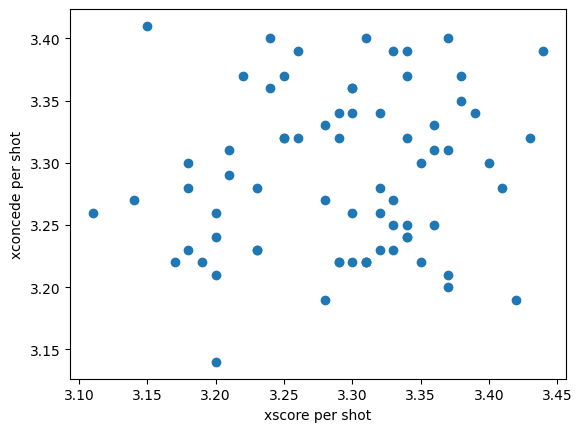

In [104]:
import matplotlib.pyplot as plt

plt.scatter(team_year_summary['xscore_per_shot'], team_year_summary['xconcede_per_shot'])
plt.xlabel('xscore per shot')
plt.ylabel('xconcede per shot')
# plt.xlim(0, 6)
# plt.ylim(0, 6)
plt.show()

Excpected Score v Shots

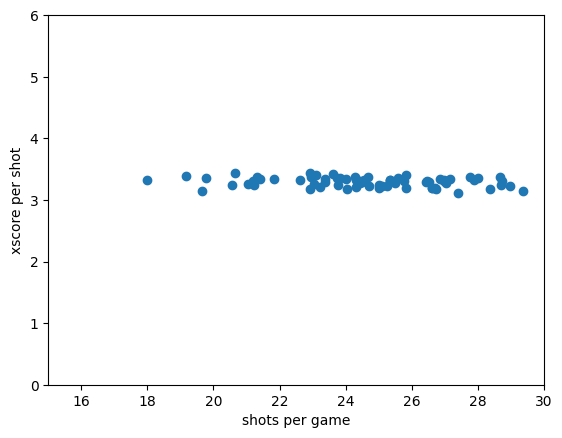

In [105]:
import matplotlib.pyplot as plt

plt.scatter(team_year_summary['shots_per_game'], team_year_summary['xscore_per_shot'])
plt.xlabel('shots per game')
plt.ylabel('xscore per shot')
plt.xlim(15, 30)
plt.ylim(0, 6)
plt.show()

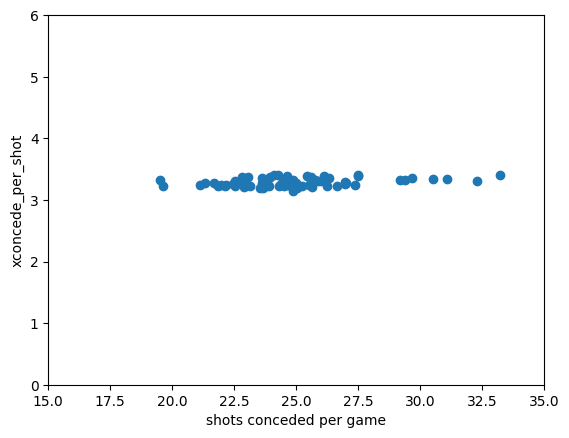

In [106]:
import matplotlib.pyplot as plt

plt.scatter(team_year_summary['shots_conceded_per_game'], team_year_summary['xconcede_per_shot'])
plt.xlabel('shots conceded per game')
plt.ylabel('xconcede_per_shot')
plt.xlim(15, 35)
plt.ylim(0, 6)
plt.show()

Diamond Scatter Plot

In [130]:
def get_diamond_plot_extents(data, x, y, x_pad, y_pad):
    
    extent_dict = {}
    extent_dict['x_mean'] = data[x].mean()
    extent_dict['y_mean'] = data[y].mean()
    extent_dict['x_max'] = data[x].max()
    extent_dict['y_max'] = data[y].max()
    extent_dict['x_min'] = data[x].min()
    extent_dict['y_min'] = data[y].min()

    extent_dict['x_extent_min'] = max(round_decimals_down(extent_dict['x_mean']-x_pad, 2), 0)
    extent_dict['x_extent_max'] = round_decimals_down(extent_dict['x_mean']+x_pad, 2)
    extent_dict['y_extent_min'] = max(round_decimals_down(extent_dict['y_mean']-y_pad, 2), 0)
    extent_dict['y_extent_max'] = round_decimals_down(extent_dict['y_mean']+y_pad, 2)
    
    return extent_dict

In [217]:
def plot_player_diamond_scatter_plot(data, x, y, x_pad, y_pad, nticks = 8, share_extent = False, annotate=False):
    
    extent_dict = get_diamond_plot_extents(data, x, y, x_pad, y_pad)
    
    if share_extent:
        extent_dict['y_extent_min'] = extent_dict['x_extent_min']
        extent_dict['y_extent_max'] = extent_dict['x_extent_max']
    
    fig = plt.figure(dpi=300)
    # fig.set_facecolor('#111111')
    plot_extents = extent_dict['x_extent_min'], extent_dict['x_extent_max'], extent_dict['y_extent_min'], extent_dict['y_extent_max']
    scaler = (extent_dict['y_extent_max'] - extent_dict['y_extent_min']) / (extent_dict['x_extent_max'] - extent_dict['x_extent_min']) 
    transform = Affine2D().scale(scaler, 1).rotate_deg(45)
    helper = floating_axes.GridHelperCurveLinear(transform, plot_extents,
                                                grid_locator1=MaxNLocator(nbins=nticks),
                                                grid_locator2=MaxNLocator(nbins=nticks)
                                                )
    
    ax = floating_axes.FloatingSubplot(fig, 111, grid_helper=helper)
    fig.add_subplot(ax)
    # ax.set_facecolor('#111111')
    # ax.axis[:].line.set_color("#FFFFFF")
    # ax.axis[:].label.set_color("#FFFFFF")
    # ax.axis[:].major_ticks.set_color("#FFFFFF")
    ax.axis[:].major_ticklabels.set(fontsize=6)
    ax.axis[:].label.set(fontsize=6)
    
    # ax.axis['left'].major_ticklabels.set_visible(False)
    # ax.axis['left'].label.set_visible(False)
    ax.axis['left'].label.set_axis_direction('bottom')

    # ax.axis['bottom'].major_ticklabels.set_visible(False)
    # ax.axis['bottom'].label.set_visible(False)
    ax.axis['bottom'].label.set_axis_direction('bottom')
    
    # ax.axis['right'].major_ticklabels.set_visible(True)
    # ax.axis['right'].label.set_visible(True)
    # ax.axis['right'].label.set_axis_direction("top")
    # ax.axis['right'].major_ticklabels.set_axis_direction("top")

    # ax.axis['top'].major_ticklabels.set_visible(True)
    # ax.axis['top'].label.set_visible(True)
    # ax.axis['top'].set_axis_direction("top")
    # ax.axis['top'].major_ticklabels.set_axis_direction("top")
    # ax.axis['top'].label.set_axis_direction("left")

    # ax.grid(visible=True, lw=0.2, ls=":", color="lightgrey")

    aux_ax = ax.get_aux_axes(transform)
    aux_ax.scatter(data[x], data[y], alpha=0.9, zorder=3, ec="w", lw=0.2)

    if annotate:
        text = list()
        data['sort'] = (data[x+"Norm"] + data[y+"Norm"]) / 2
        data_top5 = list(data.sort_values(by="sort", ascending=False).head(10).index)
        for i, name in enumerate(data_top5):
            text.append(aux_ax.annotate(name, (data.loc[name][x], data.loc[name][y]), size=4, zorder=3))
            
        adjustText.adjust_text(text, ax=ax)

    # Quadrants
    aux_ax.vlines(x=extent_dict['x_mean'], ymin=extent_dict['y_extent_min'], ymax=extent_dict['y_extent_max'], lw=0.5, ls="--")
    aux_ax.hlines(y=extent_dict['y_mean'], xmin=extent_dict['x_extent_min'], xmax=extent_dict['x_extent_max'], lw=0.5, ls="--")

    return fig, ax

In [218]:

def round_decimals_up(number:float, decimals:int=2):
    """
    Returns a value rounded up to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.ceil(number)

    factor = 10 ** decimals
    return math.ceil(number * factor) / factor

def round_decimals_down(number:float, decimals:int=2):
    """
    Returns a value rounded down to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.floor(number)

    factor = 10 ** decimals
    return math.floor(number * factor) / factor

In [219]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from mpl_toolkits.axisartist.grid_finder import MaxNLocator
# import adjustText

(0.0, 7.0)

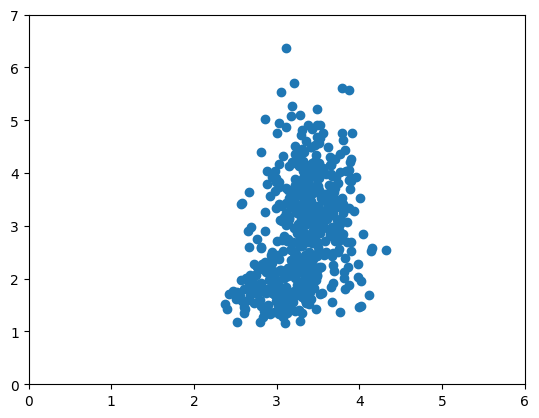

In [220]:
plt.scatter(data=player_position_year_summary, x='xscore_per_shot', y='shots_per_90pc')
plt.xlim(0, 6)
plt.ylim(0, 7)

Text(0, 0.5, 'shots_per_90pc')

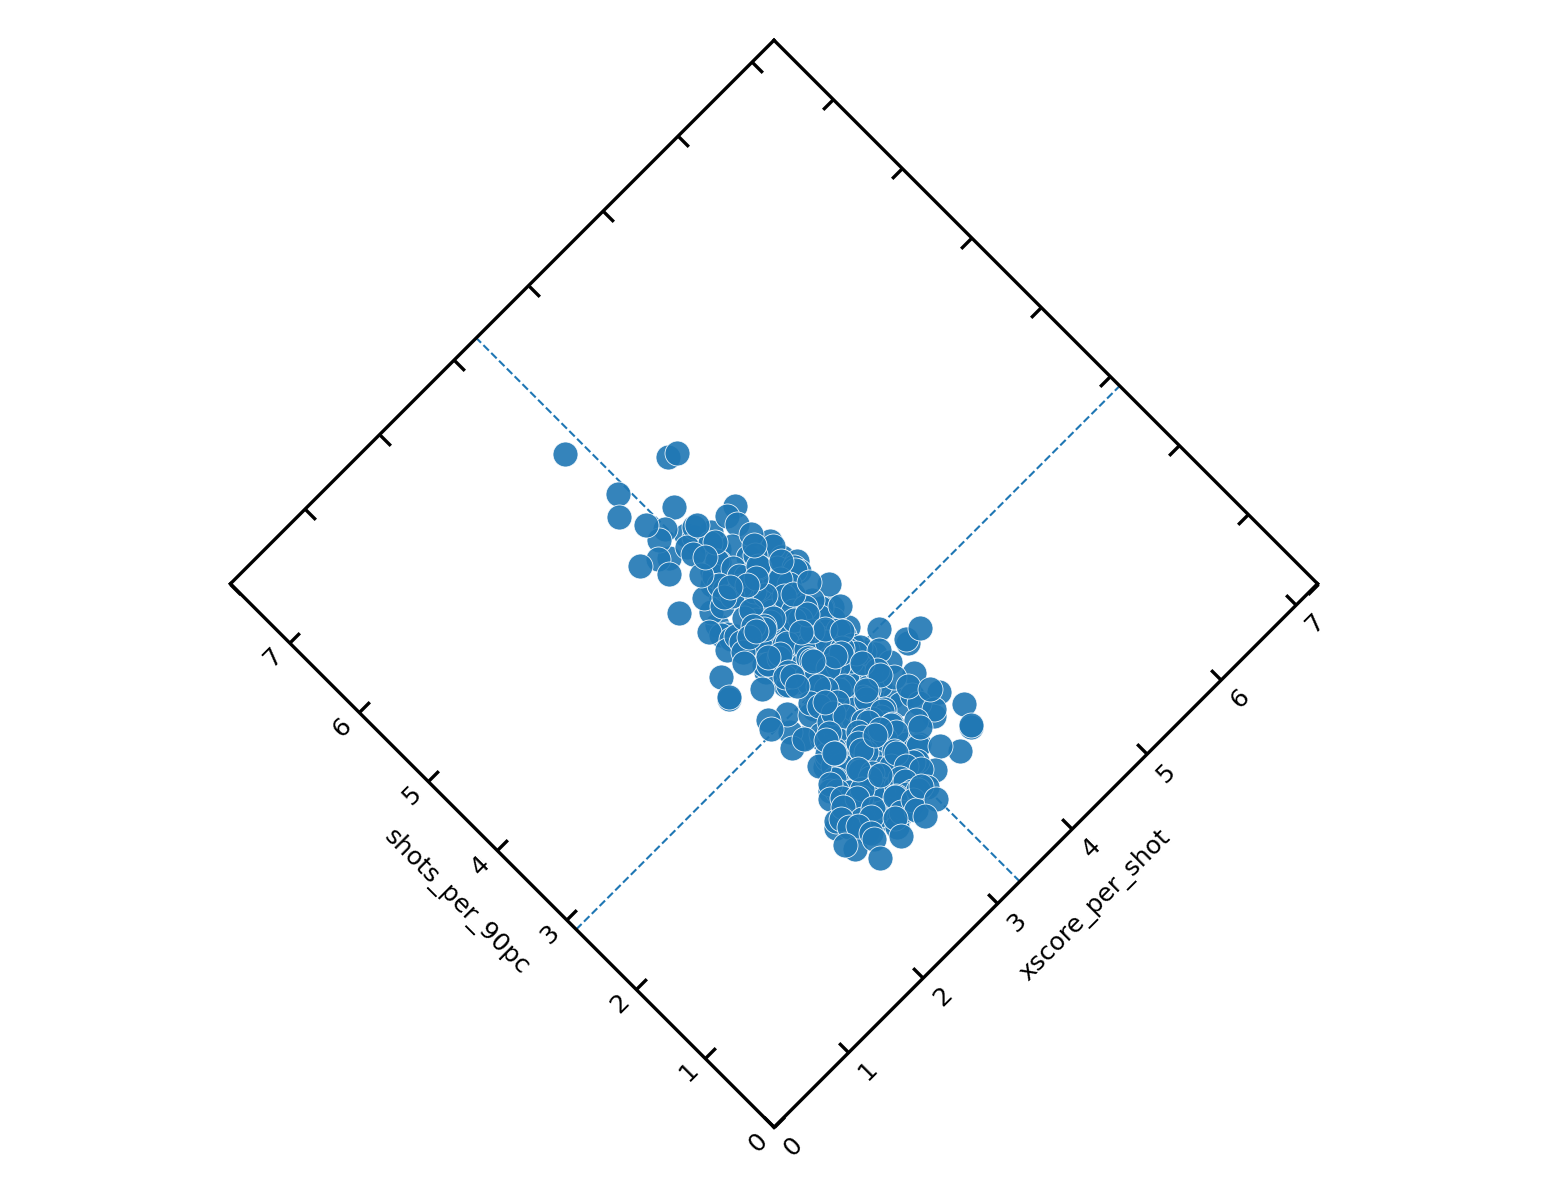

In [221]:
fig, ax = plot_player_diamond_scatter_plot(player_position_year_summary, x='xscore_per_shot', y='shots_per_90pc', x_pad=4, y_pad=5)
ax.set_xlabel('xscore_per_shot')
ax.set_ylabel('shots_per_90pc')

Raincloud Plot

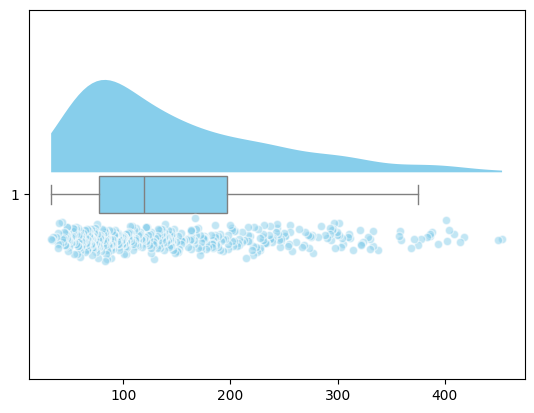

In [129]:
fig, ax = plt.subplots()

cloud = ax.violinplot(player_position_year_summary['xscore'], [1.06], showmeans=False, showextrema=False, side='high', orientation='horizontal')
for pc in cloud['bodies']:
    pc.set_facecolor('skyblue')
    pc.set_alpha(1)

# Create the box plot
c = 'grey'
box = ax.boxplot(player_position_year_summary['xscore'], vert=False, widths=0.1, patch_artist=True, showfliers=False,
            boxprops=dict(facecolor='skyblue', color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color='', markeredgecolor=c),
            medianprops=dict(color=c),
)
y = np.random.normal(1-0.12, 0.02, size=len(player_position_year_summary['xscore']))
ax.scatter(player_position_year_summary['xscore'], y, alpha=0.5, color='skyblue', zorder=2, edgecolors='white')
# ax = sns.swarmplot(x='xscore', data=player_position_year_summary, color="grey", ax=ax)
